In [5]:
library(dplyr)
library(ggplot2)
library(fitdistrplus)
library(data.table)
library(Amelia)
library(reshape2)
library(impaler)
library(gsubfn)
library(purrr)
library(randomForest)
set.seed(42)
select = dplyr::select

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: survival

Attaching package: ‘survival’

The following object is masked from ‘package:caret’:

    cluster


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

Loading required package: Rcpp
## 
## Amelia II: Multiple Imputation
## (Version 1.7.5, built: 2018-05-07)
## Copyright (C) 2005-2018 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 

Attaching package: ‘reshape2’

The following objects are masked from ‘package:data.table’:

    dcast, melt

In [7]:
FundingAmounts = read.csv('cerf allocations.csv')

# Summary Stats

In [8]:
summary(FundingAmounts)

                                         agencyName    continentName 
 United Nations Children’s Fund               :1731   Africa  :3609  
 World Food Programme                         : 971   Americas: 569  
 World Health Organization                    : 810   Asia    :1753  
 United Nations High Commissioner for Refugees: 592   Europe  :  30  
 United Nations Population Fund               : 554   Oceania :  44  
 Food and Agriculture Organization            : 506                  
 (Other)                                      : 841                  
  countryCode                             countryName     dateUSGSignature
 SDN    : 313   Republic of the Sudan           : 313   2018-03-20:  29   
 TCD    : 289   Chad                            : 289   2009-05-12:  28   
 PAK    : 253   Pakistan                        : 253   2014-04-07:  24   
 COD    : 236   Democratic Republic of the Congo: 236   2008-09-26:  23   
 CAF    : 217   Central African Republic        : 217   2012-03-2

In [299]:
head(FundingAmounts,5)

agencyName,continentName,countryCode,countryName,dateUSGSignature,emergencyTypeName,projectCode,projectID,projectTitle,regionName,tableName,totalAmountApproved,windowFullName,year,projectsectors,projectclusters,projectgroupings,projectcapcodes
Food and Agriculture Organization,Africa,BDI,Burundi,2006-09-08,Multiple,06-FAO-194,192,Distribution of disease-free cassava cuttings,Eastern Africa,M,300000.0,Underfunded Emergencies,2006,Agriculture,Food Security,,
Food and Agriculture Organization,Africa,BDI,Burundi,2006-06-28,Displacement,06-FAO-136,132,"Assistance agricole d'urgence aux populations rurales vulnérabilisées par le conflit et les aléas naturels, aux repatriés en réinstallation, ainsi qu'aux groupes spécifiques vulnérables.",Eastern Africa,M,300000.0,Underfunded Emergencies,2006,Agriculture,Food Security,,
United Nations High Commissioner for Refugees,Africa,BDI,Burundi,2006-06-28,Displacement,06-HCR-137,142,Return and reintegration of Burundian Refugees,Eastern Africa,M,699955.2,Underfunded Emergencies,2006,Multi-sector,Multi-Cluster,,
World Health Organization,Africa,BDI,Burundi,2006-09-08,Multiple,06-WHO-192,250,Epidemic surveillance and response capacities,Eastern Africa,M,306020.0,Underfunded Emergencies,2006,Health,Health,,
World Health Organization,Africa,BDI,Burundi,2006-07-14,Disruption of basic services,06-WHO-135,183,"Increase access to an essential care package for IDPs, refugees and other vulnerable.",Eastern Africa,M,1083375.0,Underfunded Emergencies,2006,Health,Health,,


In [300]:
nrow(FundingAmounts)

[1] 6005

In [301]:
colnames(FundingAmounts)

[1] "agencyName"          "continentName"       "countryCode"        
 [4] "countryName"         "dateUSGSignature"    "emergencyTypeName"  
 [7] "projectCode"         "projectID"           "projectTitle"       
[10] "regionName"          "tableName"           "totalAmountApproved"
[13] "windowFullName"      "year"                "projectsectors"     
[16] "projectclusters"     "projectgroupings"    "projectcapcodes"

# Load Features 

In [139]:
paste(feature_val,'_clean.csv',sep="")

[1] "Total_reserves_clean.csv"

In [140]:
cleanData = function(filename){
    feature_val = unlist(strsplit(filename,'\\.'))[1]
    df = read.csv(filename, sep = ",")
    df = df %>% select(-Country.Code, -Indicator.Code, -Indicator.Name)
    df = total_reserve %>% melt()
    dff = df %>% mutate(year = as.integer(substring(variable,2))) %>% 
    rename(feature_val = value) %>% select(-variable,-X)
    finaleF = paste(feature_val,'_clean.csv',sep="")
    write.csv(dff,file=finaleF)
}

In [130]:
filename = 'Total_reserves.csv'

In [ ]:
feature_val = unlist(strsplit(filename,'\\.'))[1]
df = read.csv(filename, sep = ",")
df = df %>% select(-Country.Code, -Indicator.Code, -Indicator.Name,-X)

In [127]:
df = total_reserve %>% melt()

Using Country.Name as id variables


In [131]:
dff = df %>% mutate(year = as.integer(substring(variable,2))) %>% rename(feature_val = value) %>% select(-variable)

In [133]:
write.csv(dff,file=filename)

In [141]:
cleanData('surface_area_sq_km.csv')

Using Country.Name as id variables


# Predict Population affected by disasters

In [88]:
disasterDataPop = read.csv('emdat3.csv')

In [189]:
disasterDataPop

year,iso,X.country_name,disaster.type,occurrence,Total.deaths,Injured,Affected,Homeless,Total.affected,Total.damage....000.US..
1960,BGD,Bangladesh,Flood,1,10000,NA,NA,NA,NA,NA
1960,BGD,Bangladesh,Storm,2,8149,NA,200000,NA,200000,NA
1960,CHL,Chile,Earthquake,2,6570,3000,2000000,NA,2003000,550000
1960,IND,India,Flood,4,237,NA,160000,NA,160000,NA
1960,ITA,Italy,Landslide,1,12,NA,NA,NA,NA,NA
1960,JPN,Japan,Earthquake,1,138,NA,NA,NA,NA,140000
1960,JPN,Japan,Storm,1,41,NA,NA,NA,NA,NA
1960,MAR,Morocco,Earthquake,1,12000,25000,NA,NA,25000,120000
1960,PER,Peru,Earthquake,1,57,NA,NA,NA,NA,NA
1960,PHL,Philippines (the),Earthquake,1,32,NA,NA,NA,NA,NA


In [151]:
disasterDataPop %>% filter(year == 1960)

year,disaster.group,disaster.type,occurrence,Total.deaths,Injured,Affected,Homeless,Total.affected,Total.damage....000.US..
1960,Natural,Earthquake,7,18858,28000,2000000,NA,2028000,810000
1960,Natural,Flood,5,10237,NA,160000,NA,160000,NA
1960,Natural,Landslide,2,52,NA,NA,NA,NA,NA
1960,Natural,Storm,11,9070,NA,625000,NA,625000,419000


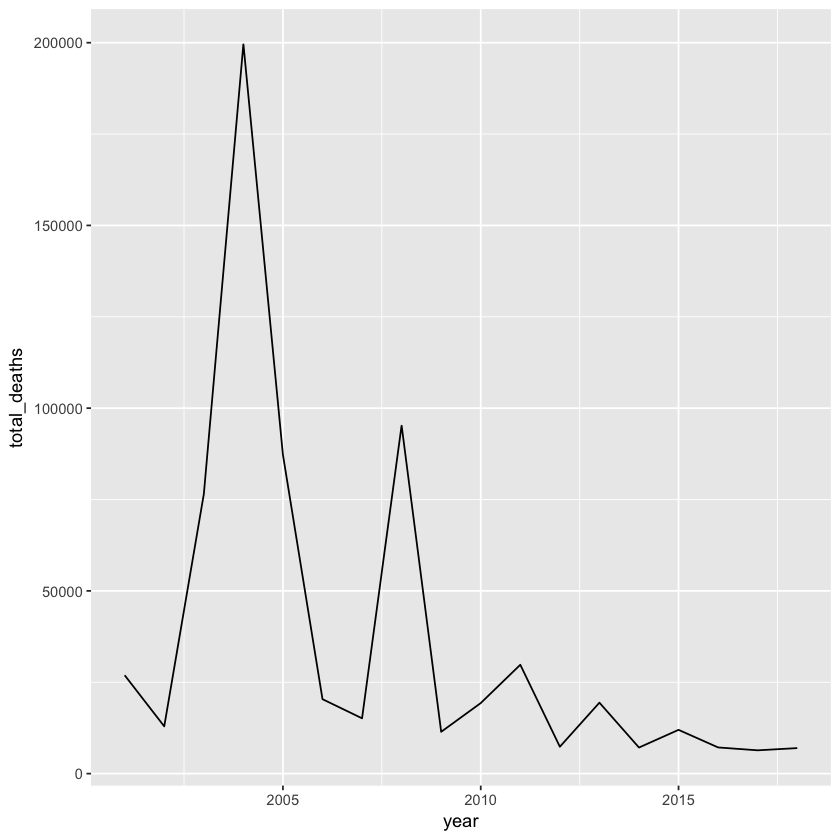

In [158]:
disasterDataPop %>% filter(year>2000) %>% group_by(year) %>% summarise(
    total_deaths = sum(Total.deaths,na.rm = TRUE)
) %>% ggplot(. , aes(x = year,y=total_deaths))+geom_line() 

In [165]:
disasterGP = disasterDataPop %>% filter(year>2000) %>% group_by(year, disaster.type) %>% summarise(
    total_d = sum(Total.deaths, na.rm = TRUE)
)

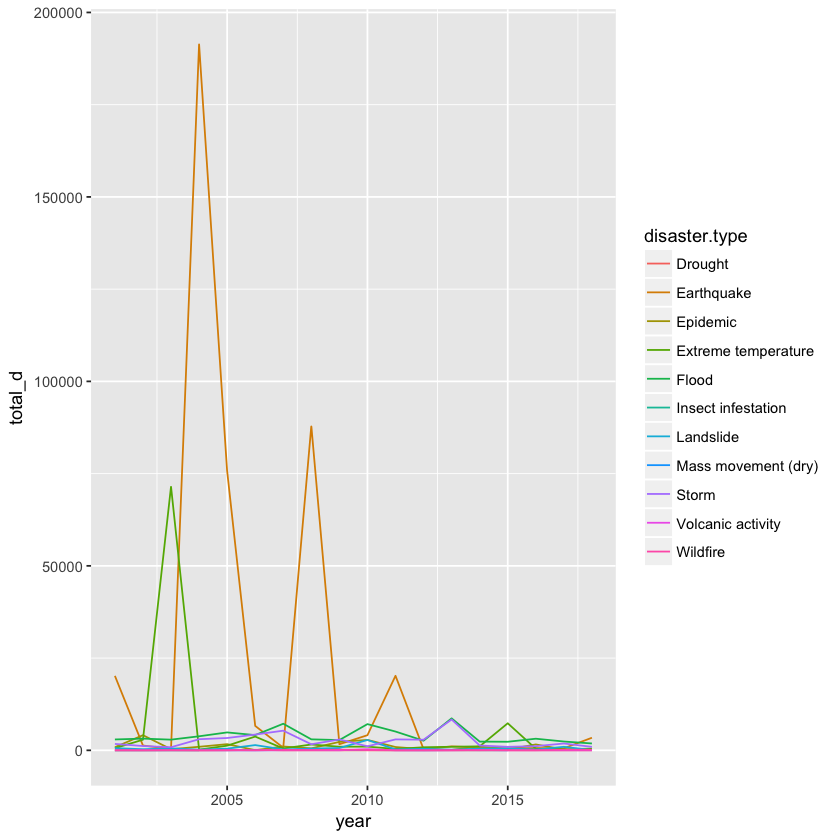

In [168]:
disasterGP %>% ggplot(.,aes(x=year,y=total_d,group=interaction(disaster.type),color=disaster.type)) + geom_line()

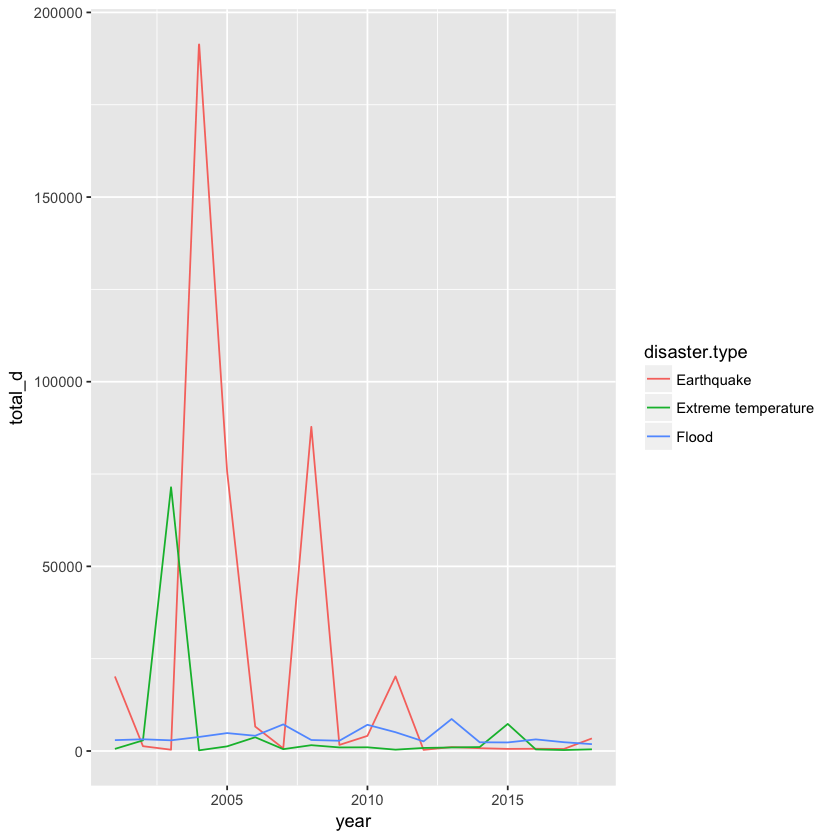

In [180]:
disasterGP %>% filter(disaster.type %in% c('Earthquake','Flood','Extreme temperature ')) %>% 
ggplot(.,aes(x=year,y=total_d,group=interaction(disaster.type),color=disaster.type)) + geom_line()

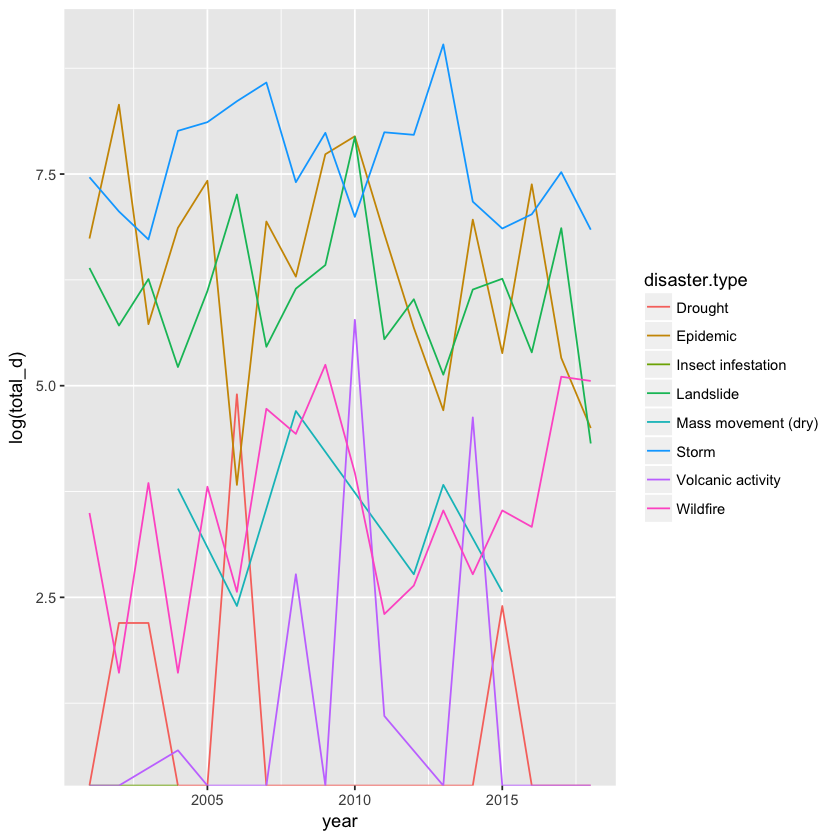

In [280]:
disasterGP %>% filter(!disaster.type %in% c('Earthquake','Flood','Extreme temperature ')) %>% 
ggplot(.,aes(x=year,y=log(total_d),group=interaction(disaster.type),color=disaster.type)) + geom_line()

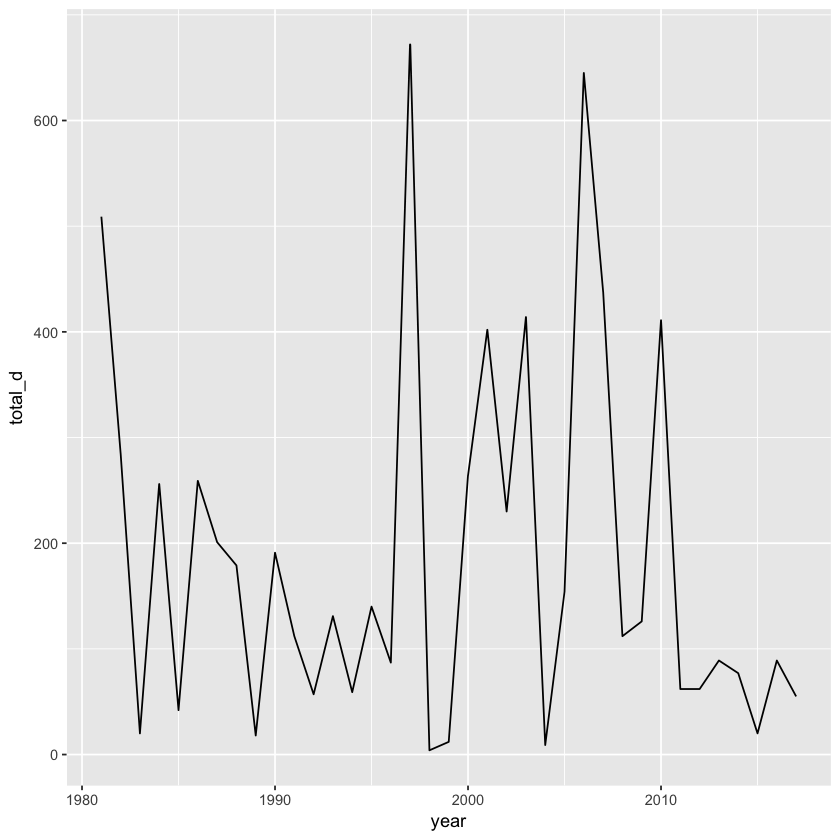

In [282]:
disasterDataPop %>% filter(disaster.type %in% c('Flood','Storm','Drought') & (X.country_name=='Indonesia') & year>1980) %>% 
group_by(year) %>% summarise(total_d = sum(Total.deaths,na.rm = TRUE)) %>% 
ggplot(.,aes(x=year,y=total_d)) + geom_line()

# Model TS

In [276]:
library(tseries)

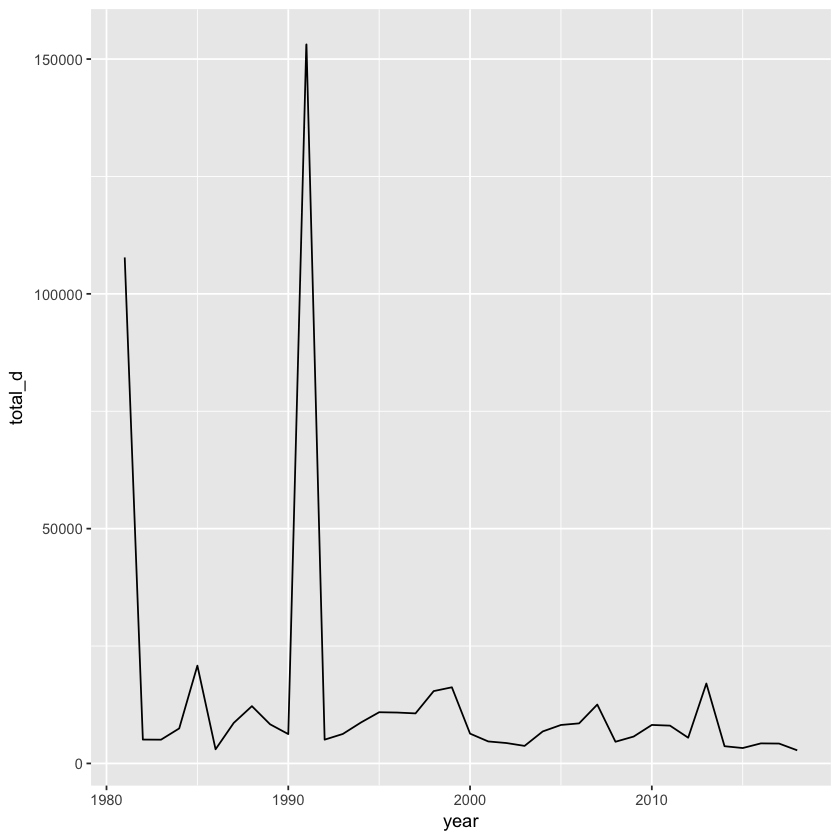

In [284]:
disasterDataPop %>% filter(disaster.type %in% c('Flood','Storm','Drought') & year>1980) %>% group_by(year) %>% summarise(total_d = sum(Total.deaths,na.rm = TRUE)) %>% 
ggplot(.,aes(x=year,y=total_d)) + geom_line()

In [271]:
tsdData2 = disasterDataPop %>% filter(disaster.type %in% c('Flood','Storm','Drought') & year>1980) %>% select(Affected, year, X.country_name)

In [272]:
tsdData = tsdData2 %>% group_by(year, X.country_name) %>% summarise(sum_Affected = sum(Affected,na.rm = TRUE))

In [275]:
tsm = ts(tsdData$sum_Affected,frequency = 1)

In [277]:
adf.test(tsm) # p-value < 0.05 indicates the TS is stationary

Warning message in adf.test(tsm):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  tsm
Dickey-Fuller = -10.751, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary


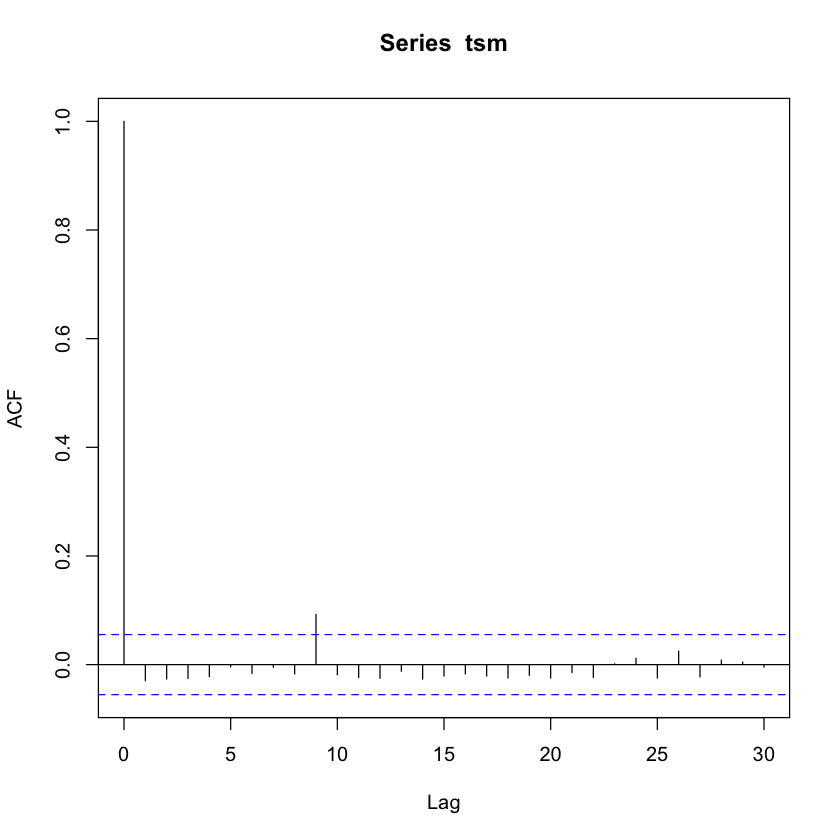

In [278]:
acf(tsm) 

In [279]:
### There is no autocorrelation

In [ ]:
## check if its additive or multiplicative

In [ ]:
decomposedRes <- decompose(tsData, type="additive") # use type = "additive" for additive components
plot (decomposedRes) # see plot below
stlRes <- stl(tsData, s.window = "periodic")

In [ ]:
#  No need for tihs since 30 data points is to less 

# Relate El nino events with funding for disasters caused by El Nino

In [1]:
## Establish a causlaity relationship b/w El Nino Event and finding for the disasters in regions affected by El Nino

In [2]:
disasters = c('Flood','Drought','Storm (hurricane, cyclone, etc.)')

### Manipulate date

In [3]:
elnino = read.csv('oceanic_nino.ascii.txt',sep="")
head(elnino, 5)

SEAS,YR,TOTAL,ANOM
1,1950,25.17,-1.34
2,1950,25.75,-1.16
3,1950,26.12,-1.18
4,1950,26.32,-1.07
5,1950,26.31,-0.85


.5 - 1 -> Medium warning
 1 -> extreme

In [9]:
elninoAlert = elnino %>% mutate(alertOrNot = ifelse(abs(ANOM)>.5 & abs(ANOM)<1 ,"MED",ifelse(abs(ANOM)>1,"HIGH", "NO")))

In [10]:
library(stringr)
elninoAlert$SEAS = str_pad(elninoAlert$SEAS, 2, pad = "0")

In [11]:
elninoAlert = elninoAlert  %>% mutate( ym = as.integer(paste(YR, SEAS,sep="")))

# Funding Data per emergency

In [158]:
head(FundingAmounts,2)

agencyName,continentName,countryCode,countryName,dateUSGSignature,emergencyTypeName,projectCode,projectID,projectTitle,regionName,tableName,totalAmountApproved,windowFullName,year,projectsectors,projectclusters,projectgroupings,projectcapcodes
Food and Agriculture Organization,Africa,BDI,Burundi,2006-09-08,Multiple,06-FAO-194,192,Distribution of disease-free cassava cuttings,Eastern Africa,M,3e+05,Underfunded Emergencies,2006,Agriculture,Food Security,,
Food and Agriculture Organization,Africa,BDI,Burundi,2006-06-28,Displacement,06-FAO-136,132,"Assistance agricole d'urgence aux populations rurales vulnérabilisées par le conflit et les aléas naturels, aux repatriés en réinstallation, ainsi qu'aux groupes spécifiques vulnérables.",Eastern Africa,M,3e+05,Underfunded Emergencies,2006,Agriculture,Food Security,,


In [161]:
fundingCerf2 = FundingAmounts %>% select(dateUSGSignature,totalAmountApproved, countryName,emergencyTypeName) %>% 
group_by(dateUSGSignature, countryName,emergencyTypeName)  %>% summarise( sumFunding = sum(totalAmountApproved,na.rm = TRUE)) 

In [12]:
fundingCerf = FundingAmounts %>% select(dateUSGSignature,totalAmountApproved, countryName) %>% 
group_by(dateUSGSignature, countryName)  %>% summarise( sumFunding = sum(totalAmountApproved,na.rm = TRUE)) 

In [13]:
allDates = fundingCerf$dateUSGSignature
allDates = as.Date(allDates,format = "%Y-%m-%d")

In [14]:
fundingCerf$ym = as.integer(format(allDates, format = "%Y%m"))

In [20]:
fundingCerf = fundingCerf %>% ungroup()

In [21]:
head(fundingCerf,2)
head(elninoAlert,2)

dateUSGSignature,countryName,sumFunding,ym
2006-03-15,Djibouti,70000,200603
2006-03-15,Eritrea,450000,200603


SEAS,YR,TOTAL,ANOM,alertOrNot,ym
01,1950,25.17,-1.34,HIGH,195001
02,1950,25.75,-1.16,HIGH,195002


In [50]:
tsdat1 = fundingCerf %>% group_by(ym) %>% summarise(sumFundingAll = sum(sumFunding)) %>% ungroup() %>% arrange(ym)

In [51]:
tsdat2 = elninoAlert %>% dplyr::select(ym, alertOrNot) %>% arrange(ym)

In [54]:
range(tsdat1$ym)
range(tsdat2$ym)

[1] 200603 201811

[1] 195001 201812

In [55]:
tsdat2 = tsdat2 %>% dplyr::filter(ym>=200603)

In [59]:
head(tsdat1,2)
head(tsdat2,2)

ym,sumFundingAll
200603,7102978
200604,16935128


ym,alertOrNot
200603,NO
200604,NO


In [77]:
highAlert = tsdat2 %>% filter(alertOrNot == "HIGH")
highAlert$alt = rep(1,nrow(highAlert))

In [76]:
tsdat1 %>% filter(ym>200700) %>% head()

ym,sumFundingAll
200701,4033251
200702,44097374
200703,85046655
200704,25664326
200705,14005503
200706,18118664


## Correlation between when there is a high alert and funding 

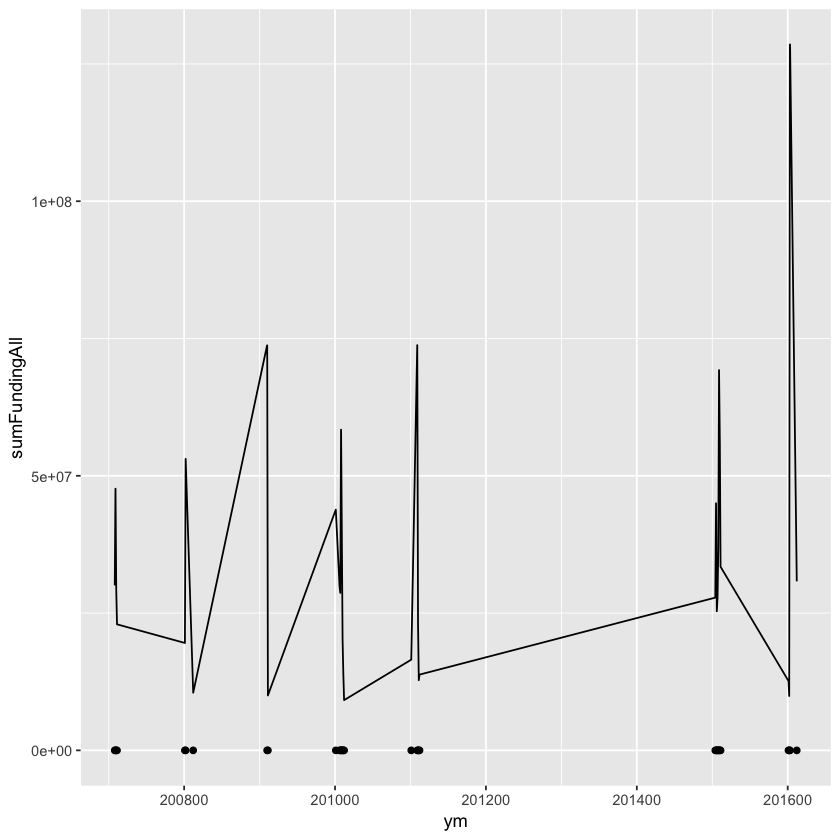

In [78]:
tsdat1 %>% inner_join(highAlert, by = "ym") %>% ggplot(.,aes(x=ym,y=sumFundingAll)) + geom_line() + geom_point(aes(x=ym, y=alt))

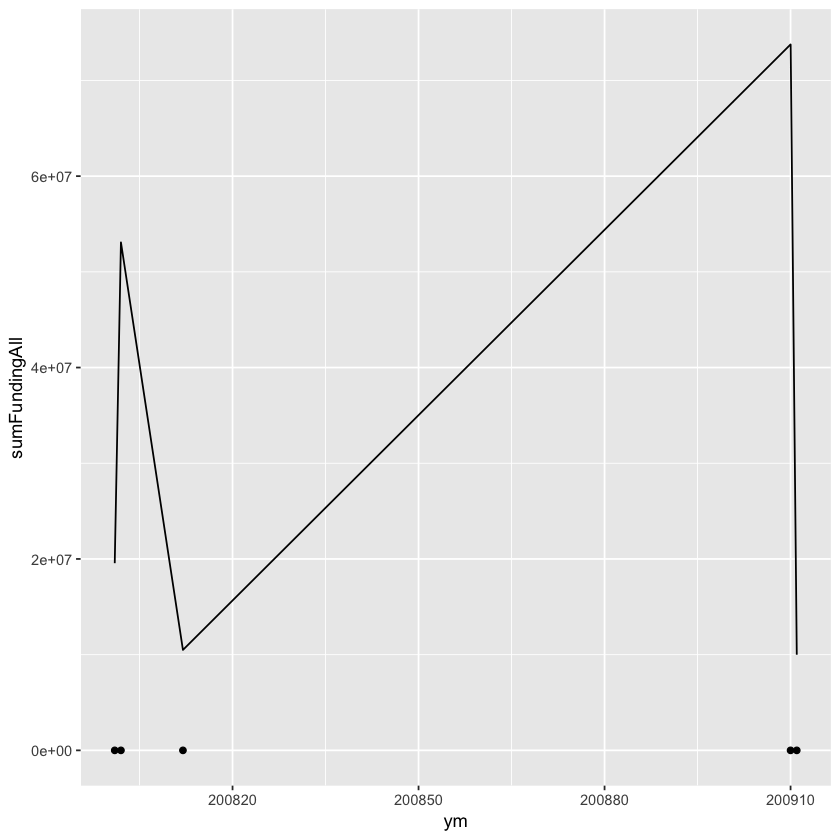

In [79]:
tsdat1 %>% inner_join(highAlert, by = "ym") %>% filter(ym > 200800 & ym<201000) %>% 
ggplot(.,aes(x=ym,y=sumFundingAll)) + geom_line() + geom_point(aes(x=ym, y=alt))

In [83]:
corDf = tsdat1 %>% inner_join(tsdat2, by = "ym")
corDf %>% group_by(alertOrNot) %>% summarise(
    meanFundingGp = mean(sumFundingAll)
)

alertOrNot,meanFundingGp
HIGH,34816507
MED,34325293
NO,37916152


find a lag in funding which can make mean for HIGH more than other labels

In [ ]:
# This needs to be check with a lag of alert without a ts model 

# Funding Analysis

In [154]:
head(disasterDataPop,2)

year,iso,X.country_name,disaster.type,occurrence,Total.deaths,Injured,Affected,Homeless,Total.affected,Total.damage....000.US..
1960,BGD,Bangladesh,Flood,1,10000,NA,NA,NA,NA,NA
1960,BGD,Bangladesh,Storm,2,8149,NA,200000,NA,200000,NA


In [156]:
popAffected = disasterDataPop %>% filter(year>2000) %>% group_by(year, disaster.type) %>% summarise(
    total_Affected = sum(Affected,na.rm = TRUE)
) 
head(popAffected,2)

year,disaster.type,total_Affected
2001,Drought,17730000
2001,Earthquake,5704592


In [157]:
popAffected2 = disasterDataPop %>% filter(year>2000) %>% group_by(year, disaster.type,X.country_name) %>% summarise(
    total_Affected = sum(Affected,na.rm = TRUE)
) 
head(popAffected2,2)

year,disaster.type,X.country_name,total_Affected
2001,Drought,Brazil,1000000
2001,Drought,Cambodia,300000


In [163]:
fundingCerf2$ym = as.integer(format(as.Date(fundingCerf2$dateUSGSignature,format = "%Y-%m-%d"), format = "%Y%m"))
fundingCerf2 = fundingCerf2 %>% ungroup()

In [164]:
head(fundingCerf2,2)

dateUSGSignature,countryName,emergencyTypeName,sumFunding,ym
2006-03-15,Djibouti,Drought,70000,200603
2006-03-15,Eritrea,Drought,450000,200603


In [168]:
fundingYear2 = fundingCerf2 %>% group_by(ym,countryName,emergencyTypeName) %>% summarise(sumFundingAll = sum(sumFunding)) %>% ungroup() %>% arrange(ym)
head(fundingYear2,2)

ym,countryName,emergencyTypeName,sumFundingAll
200603,Cote d'Ivoire,Disruption of basic services,496438
200603,Cote d'Ivoire,Other health emergency,200000


In [167]:
fundingYear = fundingCerf %>% group_by(ym,countryName) %>% summarise(sumFundingAll = sum(sumFunding)) %>% ungroup() %>% arrange(ym)
head(fundingYear,2)

ym,countryName,sumFundingAll
200603,Cote d'Ivoire,696438
200603,Djibouti,320000


In [14]:
fundingCerf$ym = as.integer(format(allDates, format = "%Y%m"))

In [20]:
fundingCerf = fundingCerf %>% ungroup()

In [106]:
joined.df.elnino.funding = elninoAlert %>% dplyr::select(ym, alertOrNot) %>% arrange(ym)  %>% inner_join(fundingYear, by = "ym")

In [170]:
joined.df.elnino.funding.final = elninoAlert %>% dplyr::select(ym, alertOrNot) %>% arrange(ym)  %>% 
inner_join(fundingYear2, by = "ym")

In [171]:
head(joined.df.elnino.funding.final,2)

ym,alertOrNot,countryName,emergencyTypeName,sumFundingAll
200603,NO,Cote d'Ivoire,Disruption of basic services,496438
200603,NO,Cote d'Ivoire,Other health emergency,200000


In [107]:
head(joined.df.elnino.funding,2)

ym,alertOrNot,countryName,sumFundingAll
200603,NO,Cote d'Ivoire,696438
200603,NO,Djibouti,320000


In [178]:
joined.df.elnino.fundingAll.final = joined.df.elnino.funding.final %>% mutate(year = as.integer(substring(ym,0,4))) %>% 
inner_join(popAffected2, by = c("year","emergencyTypeName"="disaster.type")) %>% filter(total_Affected>0)

Warning message:
“Column `emergencyTypeName`/`disaster.type` joining factors with different levels, coercing to character vector”

In [111]:
joined.df.elnino.fundingAll = joined.df.elnino.funding %>% mutate(year = as.integer(substring(ym,0,4))) %>% inner_join(popAffected, by = "year")

In [292]:
# write.csv(joined.df.elnino.fundingAll, file="mapdata.csv", row.names=F)

In [281]:
head(joined.df.elnino.fundingAll.final,10)

ym,alertOrNot,countryName,emergencyTypeName,sumFundingAll,year,X.country_name,total_Affected
200603,NO,Djibouti,Drought,320000,2006,Afghanistan,1900000
200603,NO,Djibouti,Drought,320000,2006,China,18000000
200603,NO,Eritrea,Drought,450000,2006,Afghanistan,1900000
200603,NO,Eritrea,Drought,450000,2006,China,18000000
200603,NO,Ethiopia,Drought,350000,2006,Afghanistan,1900000
200603,NO,Ethiopia,Drought,350000,2006,China,18000000
200603,NO,Kenya,Drought,4030000,2006,Afghanistan,1900000
200603,NO,Kenya,Drought,4030000,2006,China,18000000
200603,NO,Somalia,Drought,1256540,2006,Afghanistan,1900000
200603,NO,Somalia,Drought,1256540,2006,China,18000000


In [180]:
mlData = joined.df.elnino.fundingAll.final

In [276]:
head(joined.df.elnino.fundingAll ,10)

ym,alertOrNot,countryName,sumFundingAll,year,disaster.type,total_Affected
200603,NO,Cote d'Ivoire,696438,2006,Drought,19900000
200603,NO,Cote d'Ivoire,696438,2006,Earthquake,2649849
200603,NO,Cote d'Ivoire,696438,2006,Epidemic,13083
200603,NO,Cote d'Ivoire,696438,2006,Extreme temperature,0
200603,NO,Cote d'Ivoire,696438,2006,Flood,22837930
200603,NO,Cote d'Ivoire,696438,2006,Landslide,317757
200603,NO,Cote d'Ivoire,696438,2006,Mass movement (dry),0
200603,NO,Cote d'Ivoire,696438,2006,Storm,66293714
200603,NO,Cote d'Ivoire,696438,2006,Volcanic activity,74849
200603,NO,Cote d'Ivoire,696438,2006,Wildfire,0


In [289]:
joined.df.elnino.fundingAll %>% filter(total_Affected>0) %>% select(disaster.type) %>% unique()

,disaster.type
1,Drought
2,Earthquake
3,Epidemic
4,Flood
5,Landslide
6,Storm
7,Volcanic activity
592,Extreme temperature
597,Wildfire


# People affected over years

In [323]:
disasters = c('Storm','Flood','Drought')

In [357]:
joined.df.elnino.fundingAll %>% filter(alertOrNot == "HIGH") %>% mutate(elninoDisaster = ifelse(disaster.type %in% disasters,"elnino","other")) %>%
group_by(year,elninoDisaster) %>% summarise(
    sumAffectedYearType = sum(as.integer(total_Affected),na.rm=TRUE)/1000
)  %>% summary()

      year      elninoDisaster     sumAffectedYearType
 Min.   :2007   Length:14          Min.   :   48914   
 1st Qu.:2008   Class :character   1st Qu.:  208108   
 Median :2010   Mode  :character   Median : 2173121   
 Mean   :2011                      Mean   : 4981940   
 3rd Qu.:2014                      3rd Qu.: 6282316   
 Max.   :2016                      Max.   :22626463   

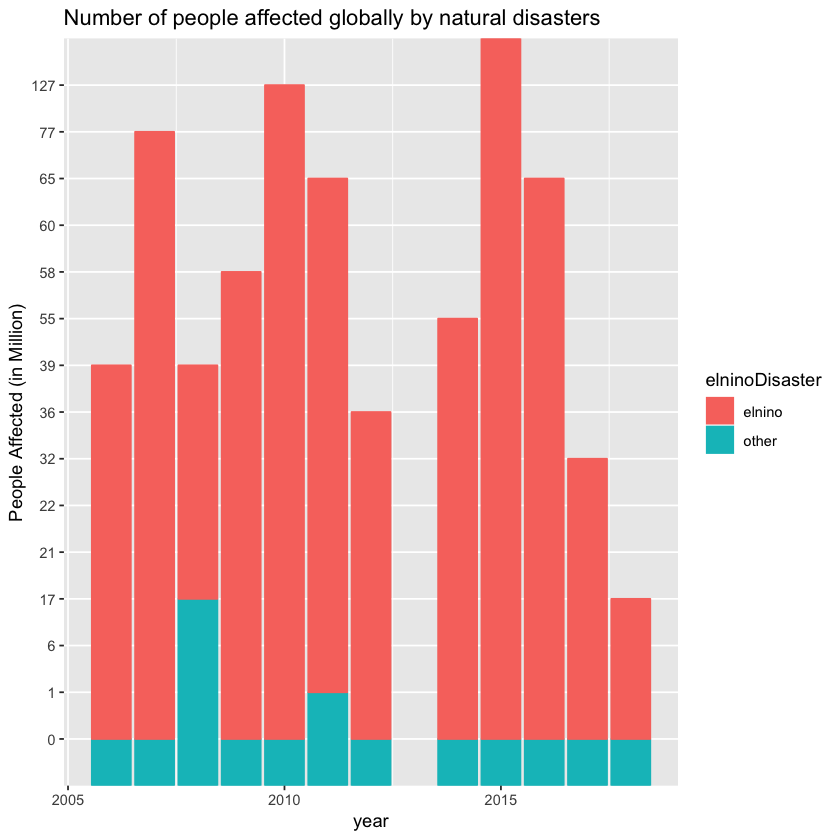

In [375]:
joined.df.elnino.fundingAll %>% filter(alertOrNot == "HIGH" | alertOrNot == "MED" ) %>% 
mutate(elninoDisaster = ifelse(disaster.type %in% disasters,"elnino","other")) %>%
group_by(year,elninoDisaster) %>% summarise(
    sumAffectedYearType = as.integer(mean(as.integer(total_Affected))/1000000)
) %>% arrange(year) %>%  ungroup() %>% 
ggplot(.,aes(x=year,y=factor(sumAffectedYearType),fill = elninoDisaster,group=interaction(elninoDisaster),color=elninoDisaster))+
geom_bar(stat="identity")+ylab("People Affected (in Million)") + ggtitle("Number of people affected globally by natural disasters")  


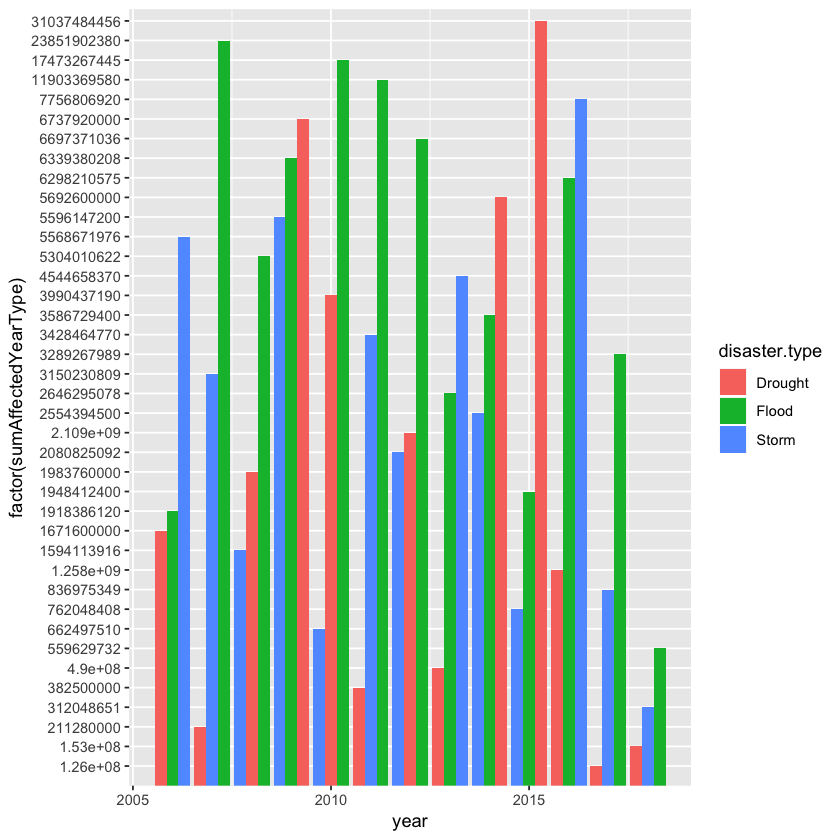

In [326]:
joined.df.elnino.fundingAll %>% filter(disaster.type %in% disasters) %>% group_by(year,disaster.type) %>% summarise(
    sumAffectedYearType = sum(as.double(total_Affected),na.rm=TRUE)
) %>% arrange(year) %>%  ungroup() %>% ggplot(.,aes(x=year,y=factor(sumAffectedYearType), fill = disaster.type))+geom_bar(stat="identity", position = "dodge")


# ggplot(.,aes(x=year,y=sumAffectedYearType,group=interaction(disaster.type),color=disaster.type)) + geom_bar(stat="identity")

## simple baseline avg approach

In [285]:
unique(joined.df.elnino.fundingAll$disaster.type)

[1] Drought              Earthquake           Epidemic            
 [4] Extreme temperature  Flood                Landslide           
 [7] Mass movement (dry)  Storm                Volcanic activity   
[10] Wildfire            
11 Levels: Drought Earthquake Epidemic Extreme temperature  ... Wildfire

In [296]:
joined.df.elnino.fundingAll %>% filter(countryName == "Peru" & disaster.type =="Flood" )

ym,alertOrNot,countryName,sumFundingAll,year,disaster.type,total_Affected
200708,HIGH,Peru,9591713,2007,Flood,171596420
201205,NO,Peru,2221613,2012,Flood,60336676
201506,HIGH,Peru,914395,2015,Flood,22141050
201704,NO,Peru,5167962,2017,Flood,52210603


In [288]:
# joined.df.elnino.fundingAll %>% group_by(year) %>% summarise()

remem the same fundingAll is due to join. take avg. 

# Xgboost ML

In [183]:
library(xgboost)
library(Matrix)

In [185]:
head(mlData,2)

ym,alertOrNot,countryName,emergencyTypeName,sumFundingAll,year,X.country_name,total_Affected
200603,NO,Djibouti,Drought,320000,2006,Afghanistan,1900000
200603,NO,Djibouti,Drought,320000,2006,China,18000000


In [262]:
mlDataClean = mlData %>% mutate(
    alertOrNot = as.numeric(as.factor(alertOrNot)),
    countryName = as.numeric(as.factor(countryName)),
    emergencyTypeName = as.numeric(as.factor(emergencyTypeName)),
    X.country_name = as.numeric(as.factor(X.country_name))
)

In [263]:
all <- 1:nrow(mlDataClean)
train_i <- sort(sample(all, round(nrow(mlDataClean)*0.80,digits = 0),replace=FALSE))
test_i <- all[-train_i]

df_train <- mlDataClean[train_i,]
df_test <- mlDataClean[test_i,]

sumFundingAll =  df_train$sumFundingAll
target_test = df_test$sumFundingAll

df_train$sumFundingAll <- NULL
df_test$sumFundingAll <- NULL

# df_train = cbind(df_train,sumFundingAll)

In [264]:
head(df_train,2)
head(df_test,2)

,ym,alertOrNot,countryName,emergencyTypeName,year,X.country_name,total_Affected
2,200603,3,27,1,2006,10,18000000
4,200603,3,33,1,2006,10,18000000


,ym,alertOrNot,countryName,emergencyTypeName,year,X.country_name,total_Affected
1,200603,3,27,1,2006,1,1900000
3,200603,3,33,1,2006,1,1900000


In [265]:
data_sparse <- as.matrix(df_train)
dtrain <- xgb.DMatrix(data = data_sparse[1:nrow(df_train), ], label = sumFundingAll) 
bstDMatrix <- xgboost(data = dtrain, max.depth = 5, eta = 0.5, nthread = 4, nrounds = 100,
                      objective = "reg:linear",eval_metric='rmse')

[1]	train-rmse:3284473.750000 
[2]	train-rmse:2503331.000000 
[3]	train-rmse:2041255.500000 
[4]	train-rmse:1882908.750000 
[5]	train-rmse:1750640.000000 
[6]	train-rmse:1698271.625000 
[7]	train-rmse:1621674.125000 
[8]	train-rmse:1460229.375000 
[9]	train-rmse:1433808.625000 
[10]	train-rmse:1366450.875000 
[11]	train-rmse:1282567.375000 
[12]	train-rmse:1227049.500000 
[13]	train-rmse:1218748.000000 
[14]	train-rmse:1179552.750000 
[15]	train-rmse:1086646.375000 
[16]	train-rmse:1024226.125000 
[17]	train-rmse:977787.687500 
[18]	train-rmse:963982.250000 
[19]	train-rmse:950349.062500 
[20]	train-rmse:864637.562500 
[21]	train-rmse:837492.125000 
[22]	train-rmse:828406.875000 
[23]	train-rmse:762606.187500 
[24]	train-rmse:735340.562500 
[25]	train-rmse:684067.187500 
[26]	train-rmse:661096.375000 
[27]	train-rmse:646403.562500 
[28]	train-rmse:631484.875000 
[29]	train-rmse:627888.000000 
[30]	train-rmse:617921.437500 
[31]	train-rmse:597383.062500 
[32]	train-rmse:581189.000000 
[

In [266]:
head(as.matrix(df_train),2)
head(as.matrix(df_test),2)

,ym,alertOrNot,countryName,emergencyTypeName,year,X.country_name,total_Affected
2,200603,3,27,1,2006,10,1.8e+07
4,200603,3,33,1,2006,10,1.8e+07


,ym,alertOrNot,countryName,emergencyTypeName,year,X.country_name,total_Affected
1,200603,3,27,1,2006,1,1900000
3,200603,3,33,1,2006,1,1900000


In [267]:
pred <- predict(object = bstDMatrix,newdata = as.matrix(df_test))

# size of the prediction vector
print(length(pred))
print(head(pred))

[1] 833
[1]  -51146.29  431560.69 3521357.50 2176041.25  310496.38 2964311.25


In [273]:
mae <- function(error)
{
    mean(abs(error))
}

In [297]:
error <- target_test - pred
 
# Example of invocation of functions
mae(error)/mean(target_test)

[1] 0.04524938

In [ ]:
predict(object = bstDMatrix,newdata = as.matrix(df_test))

# Hyperparam Opti 

In [181]:
# library(RJSONIO)
# getCountryLatLong = function(country){
#     nrowT = length(test)
#     counter = 1


#     CountryName <- gsub(' ','%20',test[1]) #remove space for URLs

#     url <- paste(
#     "http://nominatim.openstreetmap.org/search?country="
#     , CountryName
#     , "&limit=9&format=json"
#     , sep="")

#     x <- fromJSON(url)
#     d = data.frame("lati"=x[[1]]$lat,"longi"=x[[1]]$lon)
#     return(d);
# }